In [1]:
import sys
from pathlib import Path

import h5py as h5
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import palettable
import pandas as pd

sys.path.append('../lib')
from hier_group import unpack_hier_names
from local_paths import analysis_dir, database_dir, mplstyle_path
from summary_utils import verified_update, annotate_unit_df, select_units, summarize_results_per_region
from stats_utils import get_bootstrap_spread
from plot_utils import plot_region_tests, annotate_per_region_axes, axis_off_save_labels

In [2]:
plt.style.use(mplstyle_path)

# Parameters

In [3]:
analysis_name = 'self_consistency'
results_dir = analysis_dir + analysis_name

# analysis-specific conditions
conds = ('Previous', 'Current')
pal = palettable.cartocolors.qualitative.Bold_10.mpl_colors
cond_palette = dict(zip(conds, (pal[1], pal[0])))

# unit selection
unit_sel_path = database_dir + 'unit_sel/visually_selective.csv.gz'

# statistics
spread_type = 'ci_of_mean'  # estimate of center and its spread
stat_tests = (('Previous', 'Current', 'two-sided'),)  # population-level stat tests

# Load data

In [4]:
unit_df = {'Session': [], 'Unit': []}
results = {k: [] for k in ('current_rsc', 'previous_rsc')}
coords = {}

results_dir = Path(results_dir).expanduser()
for fp in results_dir.glob('*.h5'):
    with h5.File(fp, 'r') as f:
        try:
            assert f[f'progress_report/{analysis_name}/all_done'][()]
            assert isinstance(f['self_consistency/current'], h5.Group)
            assert isinstance(f['self_consistency/previous'], h5.Group)
        except (KeyError, AssertionError):
            continue

        coords_ = {}
        for cond in ('current', 'previous'):
            dset = f['self_consistency/'+cond]
            verified_update(coords, dict(time=dset['time'][()]))

            # keep only units (remove group estimates, e.g., over an array)
            unit_names = dset['unit'][()].astype(str)
            unit_names = unpack_hier_names(unit_names)
            usel = unit_names[:,0] == 'Unit'
            unit_names = unit_names[usel,1]
            verified_update(coords_, dict(unit=unit_names))

            results[cond+'_rsc'].append(dset['sample'][()][:,usel])

    unit_names = coords_['unit']
    unit_df['Session'].append(np.full(unit_names.size, fp.stem))
    unit_df['Unit'].append(unit_names)

print('coordinates:')
for k, v in coords.items():
    print('\t', k, v.shape, v.dtype)
print('results:')
for d in (results, unit_df):
    for k, v in d.items():
        d[k] = v = np.concatenate(v, axis=-1)
        print('', f'{k:<15s}', v.shape, v.dtype, sep='\t')
print(np.unique(unit_df['Session']).size, 'sessions')
unit_df = annotate_unit_df(pd.DataFrame(unit_df))

coordinates:
	 time (75,) int64
results:
	current_rsc    	(75, 66681)	float32
	previous_rsc   	(75, 66681)	float32
	Session        	(66681,)	<U10
	Unit           	(66681,)	object
678 sessions


# Select units

In [5]:
result_vals = np.array([
    results['previous_rsc'],
    results['current_rsc']])
del results

In [6]:
unit_df, unit_sel, regions = select_units(
    unit_df,
    selection_path=unit_sel_path,
    select_valid_values=result_vals)

result_vals = result_vals[...,unit_sel]
unit_df.reset_index()[['Session','Unit']].to_csv('unit_sel/fig3h.csv.gz', index=False)

> Selected units: n = 26975 of 66681 (40.5% of data, 100.0% of selection) based on visually_selective.csv.gz
> Selected units: n = 26432 of 26975 (98.0%) with valid values
> Excluded 2 rare subjects per region:
	                Units  Norm. units
	Region Subject                    
	AIT    Ot           7     0.011041
	CIT    Re          28     0.024263
  Selected units: n = 26397 of 26432 (99.9%)


# Summarize results per region

In [7]:
summary = summarize_results_per_region(
    unit_df=unit_df,
    result_vals=result_vals,
    spread_type=spread_type,
    conds=conds,
    stat_tests=stat_tests)

center/spread estimate: ci_of_mean


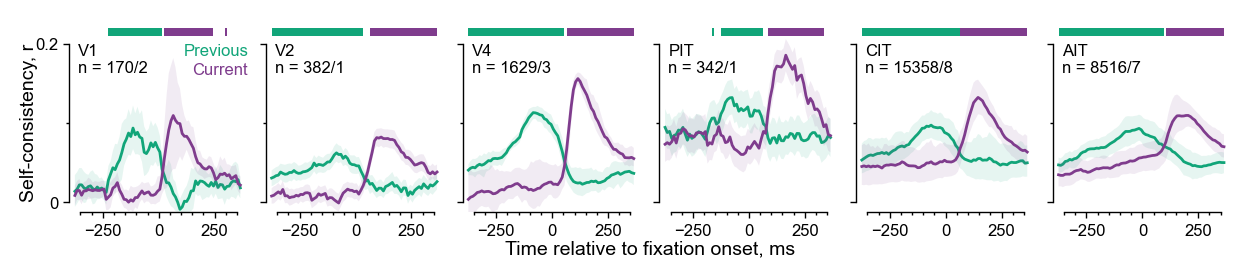

In [8]:
ncol = len(regions)
fig, axs = plt.subplots(1, ncol, figsize=(1.25*ncol,1.25), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.1)

ts = coords['time']
for region, ax in zip(regions, axs):
    m, bs = summary['one-level_center_boots'][region]
    for icond, cond in enumerate(conds):
        color = cond_palette[cond]
        ax.plot(ts, m[icond], color=color, zorder=2+icond/10)
        spread = get_bootstrap_spread(m[icond], bs[:,icond], spread_type)
        ax.fill_between(ts, *spread, ec='none', fc=color, alpha=0.1, zorder=1.95+icond/10)

ybound = (0, .2)
ymax = plot_region_tests(
    xs=ts, axs=axs, regions=regions,
    summary=summary, palette=cond_palette, ybound=ybound)

xlim = (-400, 400)
xtks = (-250, 0, 250)
xmtks = np.arange(-350, 351, 50)
for ax in axs:
    ax.set_xlim(xlim)
    ax.set_xticks(xtks)
    ax.set_xticks(xmtks, minor=True)
    ax.spines['bottom'].set_bounds(xmtks.min(), xmtks.max())

ylim = (-.0125, ymax)
ymtks = np.arange(*ybound, .1)
for ax in axs:
    ax.set_ylim(ylim)
    ax.set_yticks(ybound, list(map(str, ybound)))
    ax.set_yticks(ymtks, minor=True)
    ax.spines['left'].set_bounds(ybound)

ax = axs[0]
ax.set_ylabel('Self-consistency, r')
tform = mpl.transforms.blended_transform_factory(ax.transAxes, ax.transData)
ax.yaxis.set_label_coords(-.175, np.mean(ybound), transform=tform)

ax = fig.add_subplot(111)
axis_off_save_labels(ax)
ax.set_xlabel('Time relative to fixation onset, ms', labelpad=10)

annotate_per_region_axes(
    axs,
    regions,
    ns_per_region=summary['two-level_nunit'],
    conds=conds,
    palette=cond_palette,
    h=.875)

print('center/spread estimate:', spread_type)

plt.savefig('plots/fig3h.png')